# Author 

Sakdipat Ontoum

https://www.linkedin.com/in/sakdipat-ontoum-256bb0209/

# Introduction
# Objective
# Approach
# Dataset
# Performance Measure

 

# 1. Configurations

## 1.1 Install and Imports Library

All the install library go here. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
import datetime as dt
import math
from tqdm.auto import tqdm
import glob
import optuna

from scipy.stats.mstats import gmean
from scipy.stats import hmean


from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss


from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from scipy.stats import spearmanr

np.random.seed(0)
warnings.simplefilter("ignore")


## 1.2 Global Settings

There variables will be used across the project.

In [2]:
VAR_TH = 1.0e-03
PSEUDO_NFOLDS = 5
PSEUDO_TH = 0.95
CLIP = True
VAR_SMOOTHING = 1818

# 2. Data Preprocessing

## 2.1 Data Manipulation

In [3]:
dataset = pd.read_feather('../input/tps2022novfeather/train.ftr')
label = pd.read_csv("../input/tabular-playground-series-nov-2022/train_labels.csv")


In [4]:
train_set = dataset.loc[:19999, :]
test_set = dataset.loc[20000:, :]

del dataset
gc.collect()

display(train_set.head())

,sub_0,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,...,sub_4990,sub_4991,sub_4992,sub_4993,sub_4994,sub_4995,sub_4996,sub_4997,sub_4998,sub_4999
0,0.709336,0.799007,0.851891,0.537158,0.623930,0.705970,0.503437,0.633185,0.641550,0.666604,...,0.769207,0.750250,0.663370,0.739333,0.822384,0.749498,0.729800,0.867847,0.745888,0.787
1,0.452988,0.364453,0.567582,0.354468,0.513818,0.584119,0.454809,0.238501,0.472171,0.522314,...,0.640052,0.794052,0.721298,0.804369,0.620626,0.733606,0.816942,0.814229,0.598331,0.547
2,0.675462,0.842260,0.800013,0.525229,0.692071,0.715418,0.651008,0.609124,0.691198,0.609994,...,0.812841,0.779859,0.865657,0.828493,0.763010,0.802883,0.806891,0.896058,0.855776,0.667
3,0.481046,0.577118,0.683032,0.541356,0.630088,0.664514,0.413373,0.508210,0.526140,0.584565,...,0.824703,0.799698,0.800130,0.716604,0.603779,0.708499,0.844837,0.853057,0.850657,0.622
4,0.957339,0.910337,0.917322,0.874487,0.787595,0.854273,0.843846,0.876749,0.821128,0.913054,...,0.934803,0.900150,0.960911,0.906037,0.961240,0.935608,0.889757,0.978505,0.953681,0.934


In [5]:
print("train shape:", train_set.shape)
print("test shape:", test_set.shape)

train shape: (20000, 5000)
test shape: (20000, 5000)


In [6]:
print("train nan value sum:", train_set.isna().sum().sum())
print("test nan value sum:", test_set.isna().sum().sum())

train nan value sum: 0
test nan value sum: 0


In [7]:
print("train dublicated value sum:", train_set.duplicated().sum().sum())
print("test dublicated value sum:", test_set.duplicated().sum().sum())

train dublicated value sum: 0
test dublicated value sum: 0


## 2.2 Preprocesses

In [8]:
normalized_train_set = (train_set - train_set.mean()) / train_set.std()
normalized_train_set.var().sort_values()

sub_1825    4.930627e-32
sub_2356    1.000000e+00
sub_4963    1.000000e+00
sub_1691    1.000000e+00
sub_1685    1.000000e+00
                ...     
sub_3226    1.000000e+00
sub_2618    1.000000e+00
sub_684     1.000000e+00
sub_1148    1.000000e+00
sub_1824             NaN
Length: 5000, dtype: float64

In [9]:
for feature in ["sub_1824", "sub_1825"]:
    print(f"train {feature} unique : {train_set[feature].unique()}")
    print(f"test {feature} unique : {test_set[feature].unique()}")

train sub_1824 unique : [0.491104]
test sub_1824 unique : [0.491104]
train sub_1825 unique : [0.51]
test sub_1825 unique : [0.51]


In [10]:
train_set.max().max(), train_set.min().min()

(1.356611, -0.336521)

In [11]:
if CLIP:
    train = train_set.clip(0,1)
    test = test_set.clip(0,1)
    print(train_set.max().max(), train_set.min().min())

1.356611 -0.336521


## Adding Pseudo Labels

In [12]:
def get_pseudo_data():
    skf = StratifiedKFold(n_splits=PSEUDO_NFOLDS, random_state=0, shuffle=True)
    oof = np.zeros(train_set.shape[0])
    test_preds = np.zeros(test_set.shape[0])
    for train_index, val_index in skf.split(train_set, label["label"]):
        X_train, X_val = train_set.loc[train_index,:], train_set.loc[val_index,:]
        y_train, y_val = label.loc[train_index,"label"], label.loc[val_index,"label"]

        # Drop Low Variances
        sel = VarianceThreshold(threshold=VAR_TH)
        sel.fit(X_train / X_train.mean())
        mask = sel.get_support()

        X_train = X_train.loc[:, mask]
        X_val = X_val.loc[:, mask]
        X_test = test.loc[:, mask]

        #model = QuadraticDiscriminantAnalysis(reg_param=reg_param)
        model = LinearDiscriminantAnalysis()
        model.fit(X_train, y_train)
        val_pred = model.predict_proba(X_val)[:,1]
        test_pred = model.predict_proba(X_test)[:,1]

        oof[val_index] = val_pred
        test_preds += test_pred

        del X_train, X_val, X_test, y_train, y_val, model
        gc.collect()
    test_preds /= PSEUDO_NFOLDS
    return oof, test_preds

In [13]:
val_preds, test_preds = get_pseudo_data()

score=0.9107966396774316


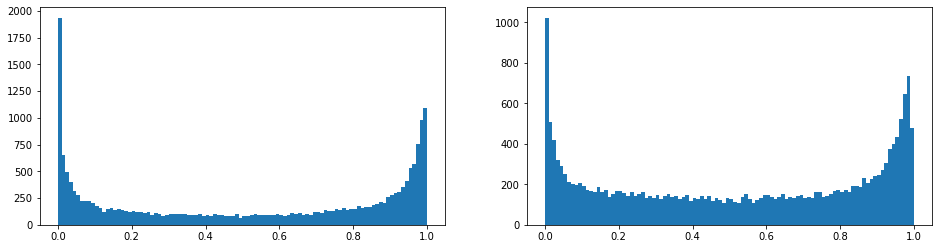

In [14]:
## LinearDiscriminantAnalysis()
print(f"score={log_loss(label['label'], val_preds)}")
fig, axes = plt.subplots(1, 2, figsize=(16,4))
axes[0].hist(val_preds, bins=100);
axes[1].hist(test_preds, bins=100);
plt.show()

proba_th: 0.977


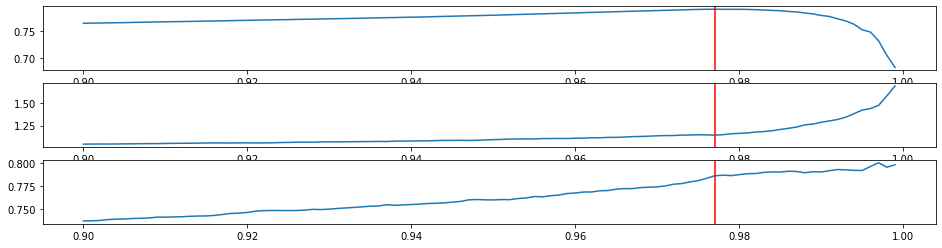

In [15]:
th_list = np.linspace(0.9, 1, 100, endpoint=False)
scores_roc, score_log, score_acc = [], [], []
proba_th, max_score = 0, 0
for th in th_list:
    condition = ((val_preds >= th) | (val_preds <= 1-th))
    new_val_preds = val_preds[condition]
    new_val_true = label.loc[condition, 'label']
    score = roc_auc_score(new_val_true, new_val_preds)
    scores_roc.append(score)
    if score > max_score:
        max_score = score
        proba_th = th
    score = log_loss(new_val_true, new_val_preds)
    score_log.append(score)
    score = accuracy_score(new_val_true, new_val_preds.round().astype(int))
    score_acc.append(score)
print("proba_th:", proba_th)
fig, axes = plt.subplots(3, figsize=(16,4))
axes[0].plot(th_list, scores_roc);
axes[0].axvline(proba_th, color='r')
axes[1].plot(th_list, score_log);
axes[1].axvline(proba_th, color='r')
axes[2].plot(th_list, score_acc);
axes[2].axvline(proba_th, color='r');

In [16]:
condition = ((test_preds >= proba_th) | (test_preds <= 1-proba_th))
train_pseudo = test.loc[condition, :]
train_pseudo['label'] = test_preds[condition].round().astype(int)
train_pseudo.reset_index(inplace=True, drop=True)
train_pseudo.to_feather("train_pseudo.ftr")

In [17]:
print("train_pseudo.shape:", train_pseudo.shape)
train_pseudo.head()

train_pseudo.shape: (3081, 5001)


,sub_0,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,...,sub_4991,sub_4992,sub_4993,sub_4994,sub_4995,sub_4996,sub_4997,sub_4998,sub_4999,label
0,0.447720,0.493394,0.541299,0.349989,0.477218,0.522883,0.514082,0.271122,0.437997,0.455650,...,0.756972,0.755393,0.763183,0.560058,0.731504,0.753920,0.698108,0.637011,0.608,0
1,0.671001,0.286648,0.246030,0.249671,0.599813,0.524274,0.349856,0.162366,0.546364,0.564960,...,0.621725,0.607564,0.716344,0.613170,0.681448,0.618902,0.456893,0.739265,0.351,0
2,0.399667,0.380014,0.535959,0.369481,0.390388,0.583791,0.883501,0.477537,0.507778,0.463148,...,0.794201,0.777806,0.736699,0.638330,0.640740,0.840357,0.649423,0.727617,0.581,0
3,0.783023,0.865336,0.982309,0.473000,0.736678,0.822831,0.890783,0.758128,0.656984,0.810206,...,0.877493,0.863662,0.822511,0.918650,0.781209,0.844733,0.919300,0.826778,0.807,1
4,0.918708,0.969526,0.994842,0.941859,0.803327,0.874479,0.934235,0.921584,0.822495,0.957115,...,0.903667,0.981070,0.970359,0.976426,0.984603,0.872210,0.980073,0.920242,0.683,1


# 3. Model Creation

In [18]:
def get_lgbm_preds(X, y, X_test, nfold=5, params_lgb={}):
    skf = StratifiedKFold(n_splits=nfold, random_state=0, shuffle=True)
    oof = np.zeros(X.shape[0])
    test_preds = np.zeros(X_test.shape[0])
    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print("\nFold {}".format(fold+1))
        dtrain = lgb.Dataset(X.loc[train_index,:], y.loc[train_index,:])
        dval = lgb.Dataset(X.loc[val_index,:], y.loc[val_index,:])
        
        evals_result = {}
        model = lgb.train(params=params_lgb, train_set=dtrain, valid_sets=[dval], num_boost_round=1000, 
                          early_stopping_rounds=50, verbose_eval=100, evals_result=evals_result)
        
        val_pred = model.predict(X.loc[val_index,:])
        test_pred = model.predict(X_test)

        oof[val_index] = val_pred
        test_preds += test_pred

        del model, dtrain, dval
        gc.collect()
    test_preds /= nfold
    return oof, test_preds

In [19]:
X = train_pseudo.drop("label", axis=1).reset_index(drop=True)
y = train_pseudo[["label"]].reset_index(drop=True)
X_test = test

def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "learning_rate": 0.01,
        "max_depth":6,
        'random_state': 42,
        "n_jobs":-1,
        "seed":123,
        "verbose":-1,
        "num_leaves":trial.suggest_int('num_leaves', 10, 200, step=10),
        "min_data_in_leaf":trial.suggest_int('min_data_in_leaf', 10, 100, step=10),
        'lambda_l1': trial.suggest_float('alpha', 0.0001, 10.0),
        'lambda_l2': trial.suggest_float('lambda', 0.0001, 10.0),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0, step=0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1.0, step=0.1),
    }
    
    '''
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    score_list = []
    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        dtrain = lgb.Dataset(X.loc[train_index,:], y.loc[train_index,:])
        dval = lgb.Dataset(X.loc[val_index,:], y.loc[val_index,:])
        
        evals_result = {}
        model = lgb.train(params=params, train_set=dtrain, valid_sets=[dval], num_boost_round=1000, 
                          early_stopping_rounds=10, verbose_eval=0, evals_result=evals_result)
        score = evals_result['valid_0']["binary_logloss"][model.num_trees()-1]
        score_list.append(score)

        del model, dtrain, dval
        gc.collect()
    '''
    
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    trainlist, validlist = [], []
    for train_index, val_index in skf.split(X, y):
        trainlist.append(train_index)
        validlist.append(val_index)
    folds = zip(trainlist, validlist)
    
    dataset = lgb.Dataset(X, y)
    res = lgb.cv(
        params, dataset, num_boost_round=1000, verbose_eval=0,
        early_stopping_rounds=10,
        folds=folds,
        stratified=False,
    )
    
    return res["binary_logloss-mean"][-1] + res["binary_logloss-stdv"][-1]

In [20]:
X = train_pseudo.drop("label", axis=1).reset_index(drop=True)
y = train_pseudo[["label"]].reset_index(drop=True)
X_test = test

params_lgb = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.01,
    "max_depth":6,
    'random_state': 42,
    "n_jobs":-1,
    "seed":123,
    "verbose":-1,
    'num_leaves': 160, 
    'min_data_in_leaf': 10, 
    'alpha': 0.5091797271529079, 
    'lambda': 0.35380392843435005, 
    'subsample': 0.9000000000000001, 
    'feature_fraction': 0.4
}

val_preds, test_preds = get_lgbm_preds(X, y, X_test, nfold=5, params_lgb=params_lgb)


Fold 1
[LightGBM] [Warning] seed is set=123, random_state=42 will be ignored. Current value: seed=123
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.273349
[200]	valid_0's binary_logloss: 0.166249
[300]	valid_0's binary_logloss: 0.135544
[400]	valid_0's binary_logloss: 0.127629
[500]	valid_0's binary_logloss: 0.127726
Early stopping, best iteration is:
[459]	valid_0's binary_logloss: 0.127111

Fold 2
[LightGBM] [Warning] seed is set=123, random_state=42 will be ignored. Current value: seed=123
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.269463
[200]	valid_0's binary_logloss: 0.158095
[300]	valid_0's binary_logloss: 0.124689
[400]	valid_0's binary_logloss: 0.117039
Early stopping, best iteration is:
[419]	valid_0's binary_logloss: 0.116638

Fold 3
[LightGBM] [Warning] seed is set=123, random_state=42 will be ignored. Current value: seed=123
Training until validation scores don't improve f

# 4. Evaluation 

score=0.13726023678532925


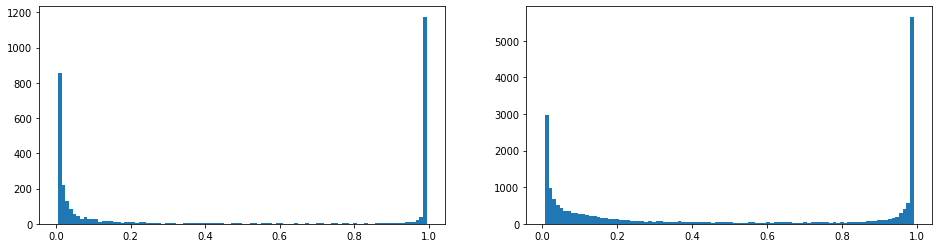

In [21]:
print(f"score={log_loss(y, val_preds)}")
fig, axes = plt.subplots(1, 2, figsize=(16,4))
axes[0].hist(val_preds, bins=100);
axes[1].hist(test_preds, bins=100);
plt.show()

In [22]:
sub = pd.read_csv('../input/tabular-playground-series-nov-2022/sample_submission.csv')
sub["pred"] = test_preds
sub.to_csv("sub_lgbm_pseudo.csv", index=False)

# Reference

https://www.kaggle.com/code/hasanbasriakcay/tpsnov22-pseudo-labels-modeling-lb-0-514


# Thank you 😆😆

